**Table of Contents:**

* [Introduction](#section1)
* [Quantum Computing](#section2)
    * [Exploration](#section2a)
    * [Forecast](#section2b)
* [3D Printing](#section3)
    * [Exploration](#section3a)
    * [Forecast](#section3b)
* [The Blockchain](#section4)
    * [Exploration](#section4a)
    * [Forecast](#section4b)
* [Conclusion](#section5)

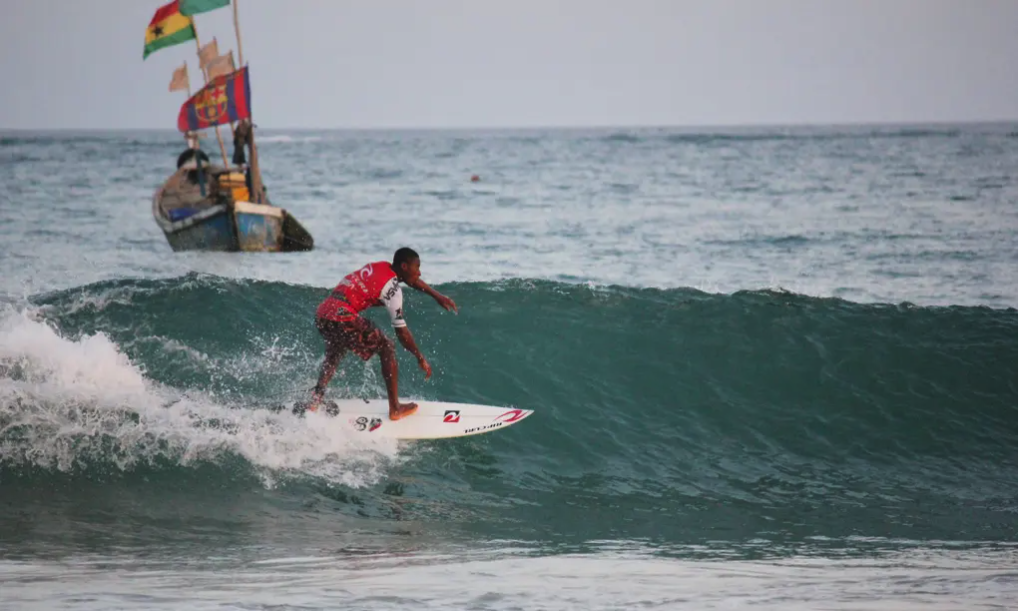

<a id="section1"></a>
# Introduction

The "Hype Cycle" is an illustrative graph developed by Gartner, a consultancy firm, to describe the process of maturity, adoption, and social application that emerging technologies go through. In this project, I aim to determine if this hype cycle is something that can be observed and forecasted using Google Trends data. The idea being that as a technology goes through the stages of the hype cycle, then it's penetration into everyday discourse will rise and fall in tandem with it's public adoption. Below, you will find an image of the hype cycle courtesy of Wikipedia.

For this analysis, we will look at quantum computing, blockchain, and 3D printing. The Google Trends data for each of these search terms will be extracted and analyzed. The data is reported in monthly intervals as a number between 0 and 100 representing the popularity of the search term, relative to it's highest peak, in the United States. A value of 100 represents the highest peak of popularity on the graph in the specified time frame. All other numbers, representing popularity, are relative this peak. Google Trends does not provide raw search numbers which, although a shame, will make the analysis easier since the datasets are already regularized for us. 

For each term, we will explore their web search, news search, and YouTube search trends, across several years, with the specific goal of identifying a hype cycle if one exists. We will then forecast these trends into the future. In this way, we'll see where the technologies are at, and where they are headed.

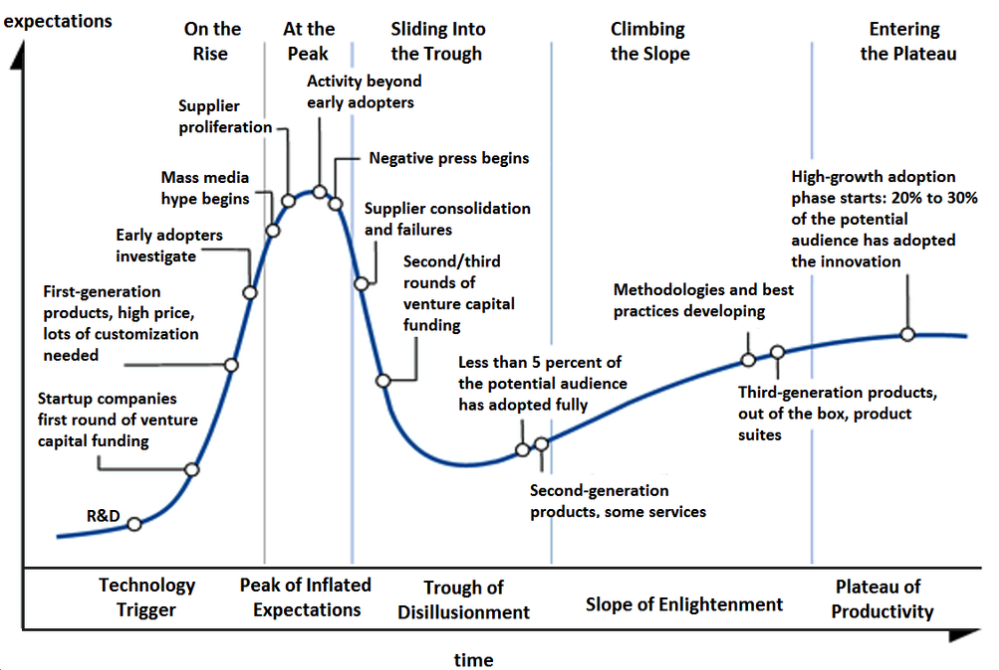

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from creds import API_KEY, API_SECRET_KEY
import random
import warnings
import math
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
# Functions used throughout this analysis

def plot_tech_trends(df, tech):
    '''
    Plots all of the tech trends of a dataframe
    '''
    
    fig,ax = plt.subplots(3,1,figsize=(16,8));

    df.iloc[:,0].plot(ax=ax[0])
    df.iloc[:,0].rolling(6).mean().dropna().plot(ax=ax[0])
    ax[0].set(ylabel="Relative Popularity", title=f"{tech} Popularity (Web Search)")

    df.iloc[:,1].plot(ax=ax[1])
    df.iloc[:,1].rolling(6).mean().dropna().plot(ax=ax[1])
    ax[1].set(ylabel="Relative Popularity", title=f"{tech} Popularity (News Search)")

    df.iloc[:,2].plot(ax=ax[2])
    df.iloc[:,2].rolling(6).mean().dropna().plot(ax=ax[2])
    ax[2].set(ylabel="Relative Popularity", title=f"{tech} Popularity (YouTube Search)")

    plt.tight_layout()
    plt.show()
    
    
def arima_fit(series):
    '''
    Fit an ARIMA model on a time series and then make predictions.
    Finds the best p,d,q parameter values and returns the best fit.
    '''
    best_pdq = ((0,0,0), 9999)
    p = d = q = range(5)
    pdq_list = list(itertools.product(p,d,q))
    
    for pdq in pdq_list:
        
        try:
            model = ARIMA(series.values, order=pdq)
            model_fit = model.fit()
            if model_fit.aic < best_pdq[1]:
                best_pdq = (pdq, model_fit.aic)
                
        except Exception:
            continue
            
    print(f"The best model fit that was found: {best_pdq}")
    
    model = ARIMA(series.values, order=best_pdq[0])
    model_fit = model.fit()
            
    return model_fit


def train_test_split(series):
    '''
    Creates a train - test split
    '''
    train, test = series[:-12], series[len(series)-12:]
    return train, test

In [3]:
# Reading in data

techs = ['quantum_computing', '3d_printing', 'blockchain']
sources = ['ws', 'ns', 'yts']

dfs = {'quantum_computing':[], '3d_printing':[], 'blockchain':[]}

for tech in techs:
    for source in sources:
        new_df = pd.read_csv(f'data/{tech}_{source}.csv', parse_dates=['Month'])
        dfs[tech].append(new_df)

In [4]:
# Combining dataframes

qc_df = dfs['quantum_computing'][0].merge(dfs['quantum_computing'][1], how='left', on='Month').merge(dfs['quantum_computing'][2], how='left', on='Month')
tdp_df = dfs['3d_printing'][0].merge(dfs['3d_printing'][1], how='left', on='Month').merge(dfs['3d_printing'][2], how='left', on='Month')
bc_df = dfs['blockchain'][0].merge(dfs['blockchain'][1], how='left', on='Month').merge(dfs['blockchain'][2], how='left', on='Month')

qc_df.columns = tdp_df.columns = bc_df.columns = ['Month', 'Popularity_ws', 'Popularity_ns', 'Popularity_yts'] 

In [5]:
# Filling in null values with 0

qc_df = qc_df.fillna(0)
tdp_df = tdp_df.fillna(0)
bc_df = bc_df.fillna(0)

In [6]:
# Setting the month as the index

qc_df.set_index('Month', inplace=True)
tdp_df.set_index('Month', inplace=True)
bc_df.set_index('Month', inplace=True)

In [7]:
qc_df.head()

,Popularity_ws,Popularity_ns,Popularity_yts
Month,,,
2004-01-01,32,0.0,0.0
2004-02-01,42,0.0,0.0
2004-03-01,26,0.0,0.0
2004-04-01,20,0.0,0.0
2004-05-01,27,0.0,0.0


In [8]:
tdp_df.head()

,Popularity_ws,Popularity_ns,Popularity_yts
Month,,,
2004-01-01,3,0.0,0.0
2004-02-01,5,0.0,0.0
2004-03-01,6,0.0,0.0
2004-04-01,5,0.0,0.0
2004-05-01,0,0.0,0.0


In [9]:
bc_df.head()

,Popularity_ws,Popularity_ns,Popularity_yts
Month,,,
2004-01-01,0,0.0,0.0
2004-02-01,0,0.0,0.0
2004-03-01,0,0.0,0.0
2004-04-01,0,0.0,0.0
2004-05-01,0,0.0,0.0


In [10]:
tdp_df.replace({'<1': '0'}, inplace=True)
tdp_df['Popularity_ws'] = tdp_df['Popularity_ws'].astype(int)

bc_df.replace({'<1': '0'}, inplace=True)
bc_df['Popularity_ws'] = bc_df['Popularity_ws'].astype(int)

<a id="section2"></a>
# Quantum Computing

<a id="section2a"></a>
## Exploration

Let's take a look at the different time series we have available for quantum computing. We'll add a moving average of 6 months as well to obtain a smoothed version of the trends.

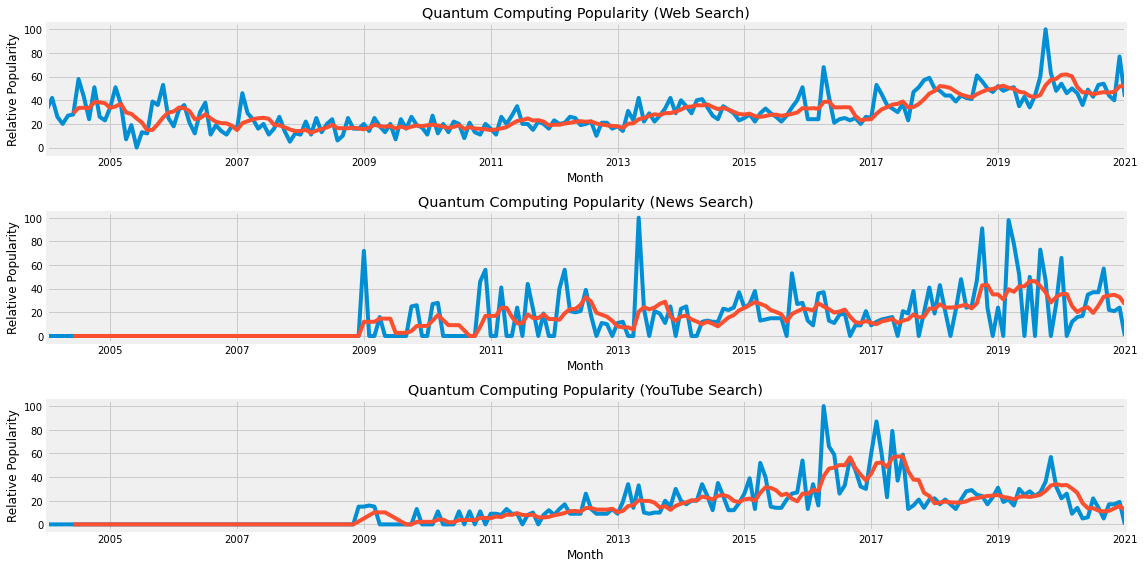

In [87]:
plot_tech_trends(qc_df, "Quantum Computing")

Looking at the graphs above, we do not see a distinct peak with a sharp drop off followed by a steady increase, which is characteristic of the hype cycle. The popularity of quantum computing in terms of web search seems to be constant since 2005 with a slight upward trend beginning in 2013. The popularity peak occurs in 2020 which is followed by a drop but nothing too drastic. If we were to zoom into the 2020 peak, we may obtain a curve more similar to what we are looking for ... let's test it out below.

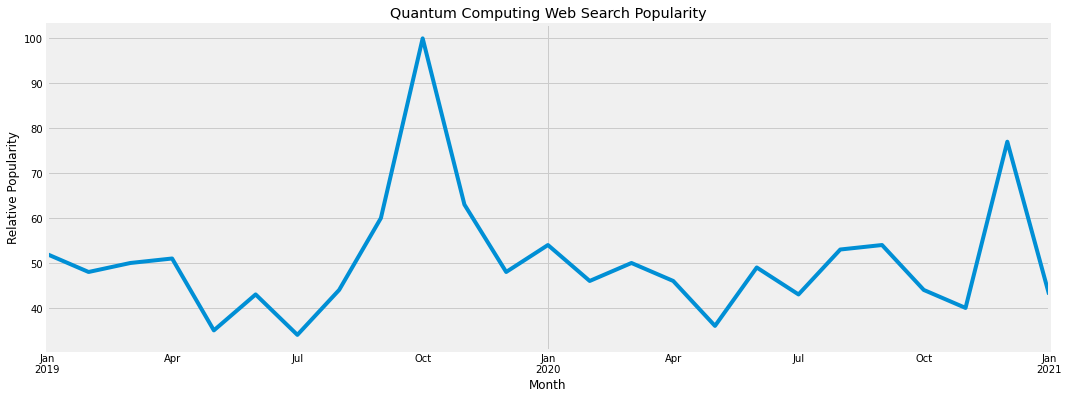

In [12]:
plt.figure(figsize=(16,6))

qc_df['2019-01-01':]['Popularity_ws'].plot();
plt.ylabel('Relative Popularity');
plt.title('Quantum Computing Web Search Popularity');

This looks a little more like it but it occurs over a short span of about 1.5 - 2 years. We are also excluding over 5+ years of foundation that was laid out before it. The popularity of quantum computing was steadily increasing long before this peak occurred. We are clearly hard-pressed to find a hype cycle in this time series.

Taking a quick look at the other trends, there seems to have been a peak in interest around quantum computing on YouTube at around 2017 which is reflected, to a much lower degree, as two spikes just before and after 2017 in web search. Although, the interest quite literally fell off in mid 2017 and has seen a steady decline ever since. Popularity in news search seems to have been constant, on average, with much larger swings throughout time. 

Taking a look at the highest peaks before the one in 2020, we can see that there are two that stand out in 2016 and 2013. After these, the average popularity seems to increase directly after. This is made evident by calculating the average popularity value for the time intervals in between the peaks. Naturally, the popularity falls right after these peaks and then a new 'normal' popularity is established.

In [13]:
mean_1 = qc_df['2007-01-01':'2013-01-01']['Popularity_ws'].mean()
mean_2 = qc_df['2013-01-01':'2017-01-01']['Popularity_ws'].mean()
mean_3 = qc_df['2017-01-01':'2019-06-01']['Popularity_ws'].mean()

print(f"Average Popularity 2007 - 2013: {mean_1}")
print(f"Average Popularity 2013 - 2017: {mean_2}")
print(f"Average Popularity 2017 - 2019: {mean_3}")

Average Popularity 2007 - 2013: 18.643835616438356
Average Popularity 2013 - 2017: 29.775510204081634
Average Popularity 2017 - 2019: 44.7


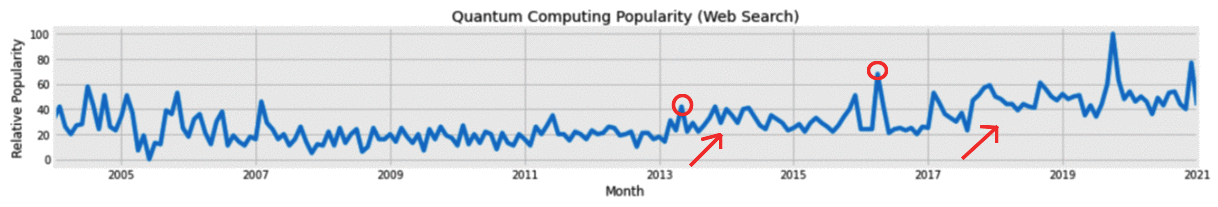
Above: The circles mark the peaks of interest and the arrows emphasize the apparent upward trend immediately after.

It seems like each successive peak in popularity is it's own hype cycle. Popularity for quantum computing spiked and deteriorated but left behind individuals with a new found interest for the topic. Then, Another spike occured and additional converts were obtained. This shows a pattern of a true hype cycle, and increase, decrease, and subtle long term increase in popularity of quantum computing occurring over and over again. 

<a id="section2b"></a>
## Forecast

Let's see what the forecast of quantum computing's web search popularity can tell us.

In [14]:
qc_train, qc_test = train_test_split(qc_df['Popularity_ws'])

In [56]:
qc_fit = arima_fit(qc_train)

The best model fit that was found: ((0, 2, 3), 1438.3200964367009)


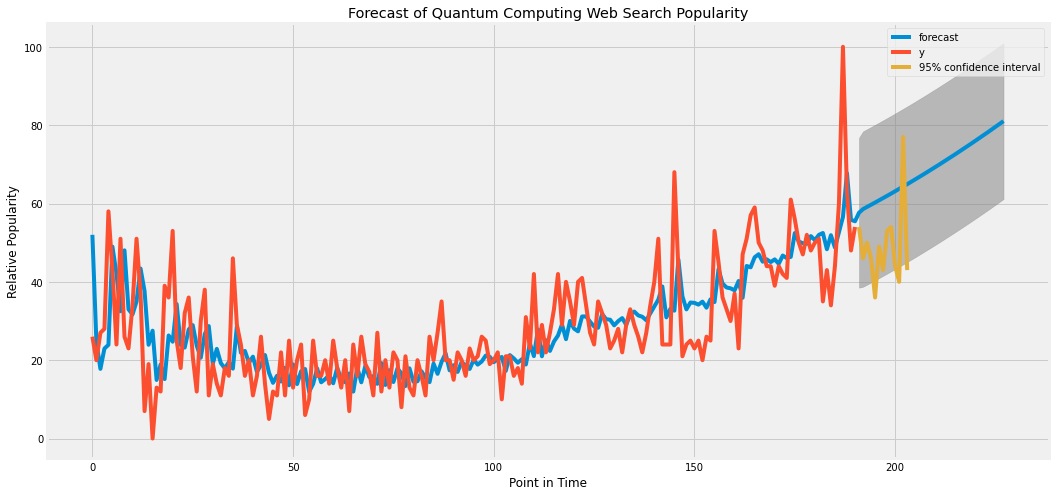

In [63]:
with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    qc_fit.plot_predict(start=2, end=len(qc_df)+24);
    qc_df.reset_index()[1:].reset_index().reindex(index=range(191,205))['Popularity_ws'].plot()
    plt.title('Forecast of Quantum Computing Web Search Popularity');
    plt.xlabel('Point in Time');
    plt.ylabel('Relative Popularity');

Our model predicts there to be continued growth in popularity of quantum computing for the next year. The portion of the graph in yellow show the portion of the dataset the model was not trained on. The model does a pretty good job considering how volatile the time series is and successfully encapsulates the unseen data within its confidence bounds. 

<a id="section3"></a>
# 3D Printing

<a id="section3a"></a>
## Exploration

We will now consider the popularity of 3D printing, also known as additive manufacturing.

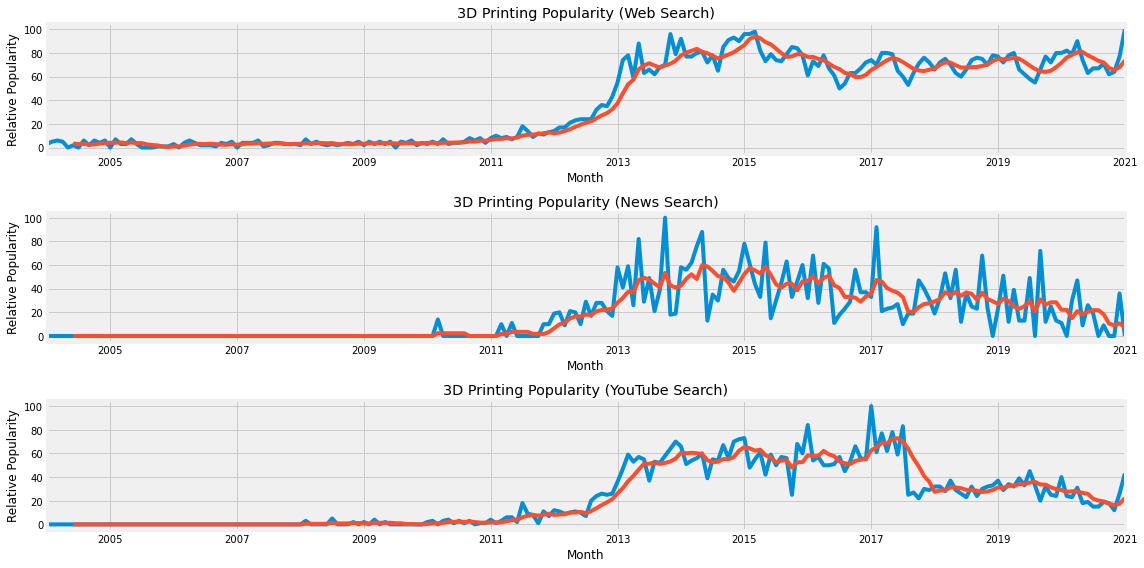

In [39]:
plot_tech_trends(tdp_df, "3D Printing")

The web search popularity of 3D printing illustrates a trend that has been slowly increasing since 2011, decreases a bit from 2015 to 2017, and plateaus for the last 4 years. Again, like we saw with quantum computing, once the technology penetrates a mainstream audience, it enjoys a new normal of popularity and interest amongst the public. 

3D printing's news search popularity peaked in 2012 and has been on the decline ever since with another peak in 2017. YouTube search show a similar downward trend at around the same times with a heavy drop-off in 2017. 

It is a little difficult to make out what the trends in news search and YouTube search tell us. This is because individuals who perform news searches and YouTube searches are likely to be a small subset of the public relative to those who perform web searches. In addition, if the raw number of news searches and YouTube searches were small, then we would see much more volatility in the trend than web searches which is bound to be magnitudes of order larger and, therefore, require much greater numbers to significantly drop or rise the curve. This is exactly what we observe here. Nonetheless, we can say that fewer people are searching YouTube and the news for 3D printing compared to 2012 and 2017.

The rise, fall, and plateaus we see in web searches from 2013 - 2017 may be an artifact of a hype curve. Although, this could simply be reversion to the mean; once a trend enjoys an abnormal spike, it will naturally decrease back down to a steady level. That is what the hype cycle illustrates at the end of the day, a reversion to the mean after media hype. This one is a little too close to call.

<a id="section3b"></a>
## Forecast

In [66]:
tdp_train, tdp_test = train_test_split(tdp_df['Popularity_ws'])

In [70]:
tdp_fit = arima_fit(tdp_train)

The best model fit that was found: ((4, 1, 3), 1246.8371028876645)


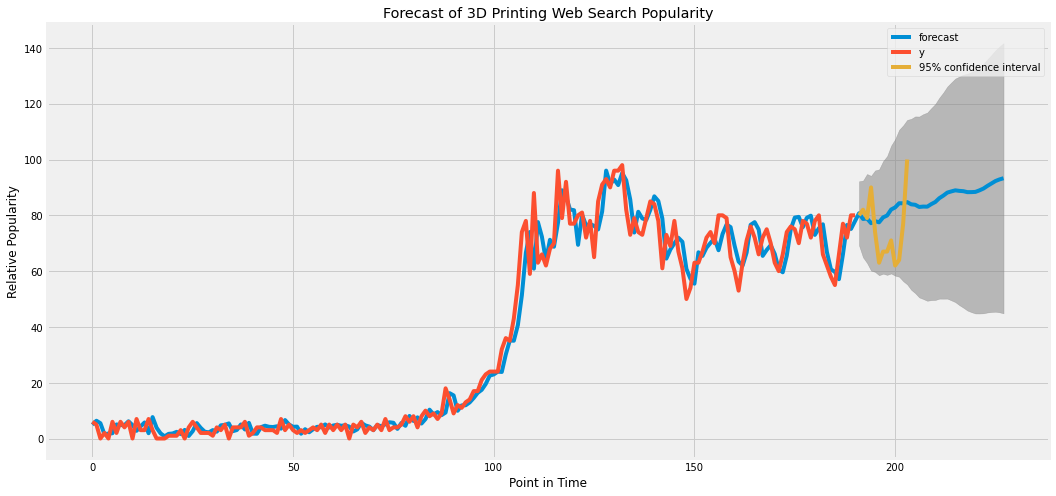

In [71]:
with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    tdp_fit.plot_predict(start=2, end=len(qc_df)+24);
    tdp_df.reset_index()[1:].reset_index().reindex(index=range(191,205))['Popularity_ws'].plot()
    plt.title('Forecast of 3D Printing Web Search Popularity');
    plt.xlabel('Point in Time');
    plt.ylabel('Relative Popularity');

Our forecast for the web search popularity of 3D printing predicts an increasing trend in the next year. The unseen data is encapsulated in the confidence bounds which is great, but they seem to be markedly wider than those for quantum computing. This shows that there is some uncertainty about 3D's popularity in our model. Seeing as 3D printing is a relatively established technology that is continuously being advanced, it is safe to say that the technology is here to stay and we should anticipate further adoption and increase in popularity in the future. 

<a id="section4"></a>
# Blockchain

<a id="section4a"></a>
## Exploration

Finally, we will take a look at the blockchain. Since it looks like the technology was practically invisible to the public eye before 2017, we'll zoom in starting from 2016.

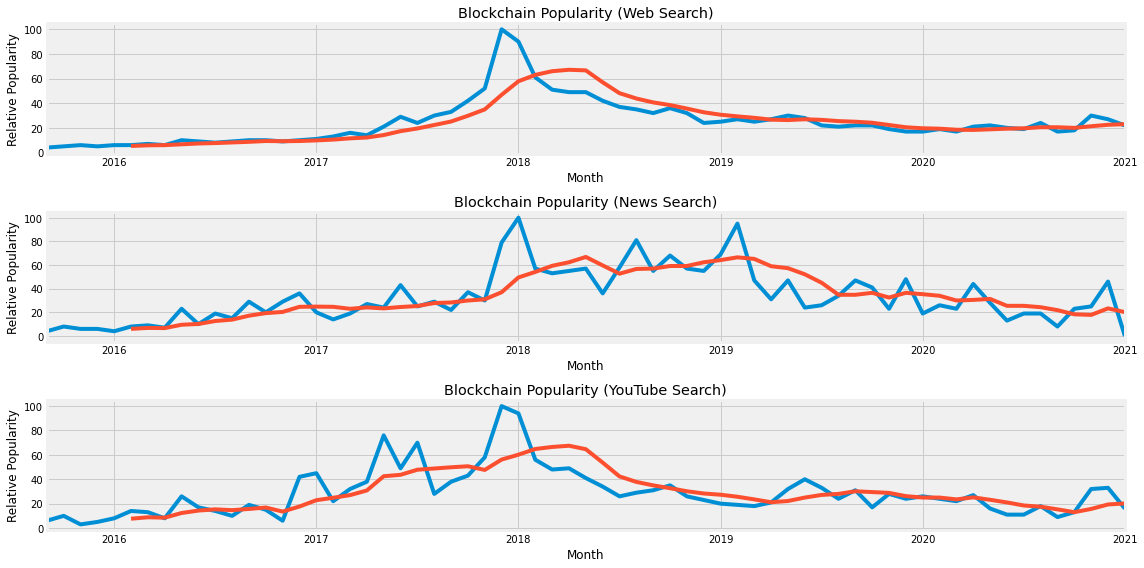

In [76]:
plot_tech_trends(bc_df.iloc[140:,:], "Blockchain")

Blockchain's popularity is probably the closest we have come to a hype cycle. The rapid increase and sharp drop is quite characteristic of a hype cycle but there is no steady increase any time afterwards. Although, because the tech has penetrated the public consciousness, it enjoys a new normal level of popularity at 20. The trends of news and YouTube searches exhibit very similar trends. 

The blockchain is a very abstract concept with a very narrow field of application and has been closely tied to cryptocurrency. Seeing as the technology is highly specialized, abstract, and immaterial, it is easy to understand why many people lost interest in it. Similarly, as individuals were striking gold in the BitCoin market, it is easy to understand why it exploded in popularity. Now, the blockchain remains a buzzword but some believe it holds much promise in the field of cybersecurity and online banking. Although, these promises are yet to be actualized on a large scale. Perhaps, blockchain is just entering its own slope of enlightenment.   

<a id="section4b"></a>
## Forecast

In [77]:
bc_train, bc_test = train_test_split(bc_df['Popularity_ws'])

In [78]:
bc_fit = arima_fit(bc_train)

The best model fit that was found: ((3, 1, 3), 1117.51727081654)


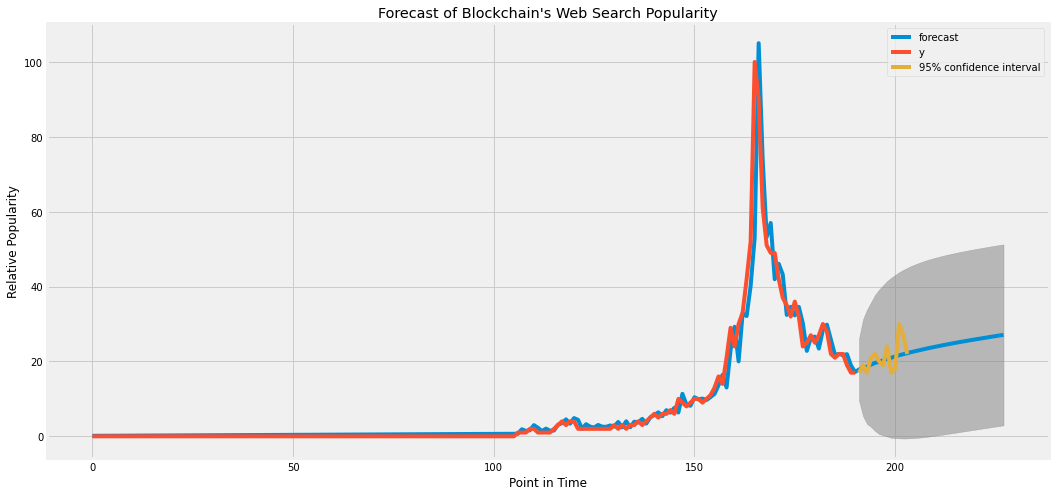

In [80]:
with plt.rc_context():
    plt.rc("figure", figsize=(16,8))
    bc_fit.plot_predict(start=2, end=len(qc_df)+24);
    bc_df.reset_index()[1:].reset_index().reindex(index=range(191,205))['Popularity_ws'].plot()
    plt.title("Forecast of Blockchain's Web Search Popularity");
    plt.xlabel('Point in Time');
    plt.ylabel('Relative Popularity');

Looking at the forecast above, we may be excited to see that we have a textbook hype cycle staring us in the face. The boom, the bust, the steady redemption arc, it's got it all. This is a good model fit seeing as the unseen data is captured in the confidence bounds and very close to the point predictions made by the model as well. Wisely, the model provides it with a large confidence interval learning from it's peak 4 years ago. 

<a id="section5"></a>
## Conclusion

The hype cycle postulates that emerging technologies go through a series of maturation and adoption stages before they become ubiquitous in our everyday lives. In this analysis, we look at 3 emerging technologies, 3D printing, the blockchain, and quantum computing to determine if we can observe this hype cycle in the natural world using Goolge Trends data to gauge public interest in the technologies over the span of several years. 

In our analysis, we found quantum computing's web search to possess multiple instances of peaks in popularity followed by a drop down to a new normal of popularity greater than it had before the peak. Essentially, going through multiple hype cycles. 3D printing exhibited a gradual crescendo of popularity which slightly declined after its climax but maintains a relatively high level of popularity to this day. This could be characterized as a long drawn out hype cycle. Blockchain had the most distinct hype cycle form with a very rapid peak and sharp decline thereafter.

Although we've used a measly sample size of 3 technologies to conduct our analysis, I believe it is safe to say that **there is no strong evidence for the hype cycle**. The hype cycle is characterized as a dramatic increase in popularity with a drop after which a technology slowly creeps into our everyday lives. Real life is not so clear cut and dry. In the technologies we looked at, we found artifacts of a hype cycle; a marked increase in popularity followed by a drop and a new, increased norm of popularity or steady increase. Although, each trend possessed these traits to varying degrees. 

In practice, the hype curve could very well be seen as a class of different kinds of trends with some variation between them but following the trade marks of what Gartner originally put forward. Some technologies may experience something more akin to a hype step function, with new advancements in a technology leading to new instances of hype which die down but lead to new levels of hype which may server as a catalyst for yet a new hype peak and the pattern continues as a true cycle; as was the case with quantum computing. Other technologies are easier to adopt and apply in practice leading to a steady increase in popularity followed by a leveling off as was seen with 3D printing. Yet other technologies may be more abstract and specialized making it difficult for the public to adopt it leading to text book examples of the hype cycle as was seen with the blockchain.

George Box, a British statistician ones said that *"all models are wrong but some are useful"*. This saying could not be any more true here. No, emerging technologies may not go through a standardized pattern of hype, die down, and widespread adoption. But, we can not say that such a model is not useful when forecasting the adoption of an emerging technology. 